In [1]:
!pip install --upgrade pip
!pip install paddleocr==2.8.1 paddlepaddle-gpu==2.6.1
!pip install opencv-python==4.10.0.84 imgaug==0.4.0 fire==0.7.1 rapidfuzz==3.14.1 python-docx==1.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.9/758.9 MB 48.7 MB/s  0:00:08
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 37.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 127.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 89.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 3.7 MB/s  0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.

In [2]:
import os
import cv2
from paddleocr import PaddleOCR, draw_ocr
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

INPUT_DIR = '/kaggle/input/ocr-testing-images'
OUTPUT_DIR = '/kaggle/working/results'

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"✅ Input: {INPUT_DIR}")
print(f"✅ Output: {OUTPUT_DIR}")

✅ Input: /kaggle/input/ocr-testing-images
✅ Output: /kaggle/working/results


In [3]:
ocr = PaddleOCR(use_angle_cls=True, lang='en')
print("✅ PaddleOCR initialized.")

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:17<00:00, 232kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10.2M/10.2M [00:20<00:00, 504kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:08<00:00, 256kiB/s]

[2025/10/20 08:13:27] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_ch

✅ PaddleOCR initialized.


In [4]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"❌ Could not read image at: {image_path}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh, img

In [5]:
def run_paddleocr(image_path, output_dir):
    import os
    from paddleocr import draw_ocr
    from PIL import Image, ImageFont

    basename = os.path.splitext(os.path.basename(image_path))[0]
    image_output_dir = os.path.join(output_dir, basename)
    os.makedirs(image_output_dir, exist_ok=True)

    result = ocr.ocr(image_path, cls=True)

    boxes = [line[0] for line in result[0]]
    texts = [line[1][0] for line in result[0]]
    scores = [line[1][1] for line in result[0]]

    original = cv2.imread(image_path)

    # Auto-detect a usable font
    possible_fonts = [
        "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",
        "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf",
        "/usr/share/fonts/truetype/freefont/FreeSans.ttf"
    ]

    font_path = next((f for f in possible_fonts if os.path.exists(f)), None)
    if font_path is None:
        font_path = ImageFont.load_default()

    im_show = draw_ocr(original, boxes, texts, scores, font_path=font_path)
    annotated_path = os.path.join(image_output_dir, f"{basename}_annotated.jpg")
    Image.fromarray(im_show).save(annotated_path)

    text_path = os.path.join(image_output_dir, f"{basename}_text.txt")
    with open(text_path, "w", encoding="utf-8") as f:
        for t, s in zip(texts, scores):
            f.write(f"{t} (conf: {s:.2f})\n")

    print(f"✅ Processed: {basename}")
    return result

In [6]:
image_paths = [
    '/kaggle/input/ocr-testing-images/Receipt.jpg',
    '/kaggle/input/ocr-testing-images/Product_Packaging.jpg',
    '/kaggle/input/ocr-testing-images/City_Scene.jpg'
]

valid_images = [p for p in image_paths if os.path.exists(p)]
print(f"✅ Found {len(valid_images)} valid images.")


✅ Found 3 valid images.


In [7]:
results = {}
for path in valid_images:
    results[path] = run_paddleocr(path, OUTPUT_DIR)

[2025/10/20 08:13:31] ppocr DEBUG: dt_boxes num : 52, elapsed : 1.6113708019256592
[2025/10/20 08:13:32] ppocr DEBUG: cls num  : 52, elapsed : 0.16997051239013672
[2025/10/20 08:13:32] ppocr DEBUG: rec_res num  : 52, elapsed : 0.35675930976867676
✅ Processed: Receipt
[2025/10/20 08:13:32] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.08483076095581055
[2025/10/20 08:13:32] ppocr DEBUG: cls num  : 37, elapsed : 0.23721933364868164
[2025/10/20 08:13:33] ppocr DEBUG: rec_res num  : 37, elapsed : 0.14513134956359863
✅ Processed: Product_Packaging
[2025/10/20 08:13:33] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.06298375129699707
[2025/10/20 08:13:33] ppocr DEBUG: cls num  : 14, elapsed : 0.038423776626586914
[2025/10/20 08:13:33] ppocr DEBUG: rec_res num  : 14, elapsed : 0.056860923767089844
✅ Processed: City_Scene


In [8]:
import json

CROP_DIR = os.path.join(OUTPUT_DIR, "crops")
os.makedirs(CROP_DIR, exist_ok=True)
metadata = []

for img_idx, img_path in enumerate(valid_images):
    img = cv2.imread(img_path)
    result = results[img_path]

    for box_idx, line in enumerate(result[0]):
        box = line[0]
        text = line[1][0]
        score = line[1][1]

        x_coords = [pt[0] for pt in box]
        y_coords = [pt[1] for pt in box]
        x1, y1, x2, y2 = int(min(x_coords)), int(min(y_coords)), int(max(x_coords)), int(max(y_coords))

        crop = img[y1:y2, x1:x2]
        crop_id = f"{img_idx}_{box_idx}"
        crop_path = os.path.join(CROP_DIR, f"{crop_id}.jpg")
        cv2.imwrite(crop_path, crop)

        metadata.append({
            "id": crop_id,
            "image_filename": os.path.basename(img_path),
            "bbox": [x1, y1, x2, y2],
            "score": float(score),
            "paddle_text": text,
            "crop_path": f"crops/{crop_id}.jpg"
        })

json_path = os.path.join(OUTPUT_DIR, "boxes.json")
with open(json_path, "w") as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Saved {len(metadata)} entries to {json_path}")
print(f"✅ Crops stored in: {CROP_DIR}")


✅ Saved 103 entries to /kaggle/working/results/boxes.json
✅ Crops stored in: /kaggle/working/results/crops


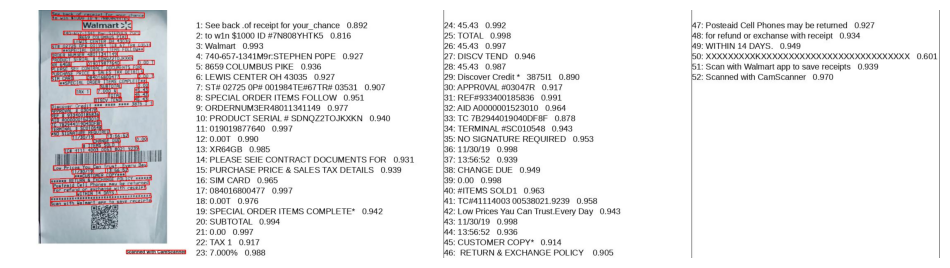

In [9]:
sample_image = os.path.join(OUTPUT_DIR, 'Receipt', 'Receipt_annotated.jpg')
if os.path.exists(sample_image):
    img = cv2.imread(sample_image)
    plt.figure(figsize=(12, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("⚠️ No sample annotated image found.")

In [10]:
import shutil

RESULTS_DIR = "/kaggle/working/results/"
os.makedirs(RESULTS_DIR, exist_ok=True)

for file in os.listdir("."):
    if file.endswith(".jpg") or file.endswith(".txt"):
        shutil.move(file, os.path.join(RESULTS_DIR, file))

print("✅ All .jpg and .txt files moved to:", RESULTS_DIR)
print("📦 Next: 'Save Version' → 'Save & Run All' → 'Add to Dataset'.")
print("➡️ You can now use this dataset in Notebook 2 (TrOCR).")

✅ All .jpg and .txt files moved to: /kaggle/working/results/
📦 Next: 'Save Version' → 'Save & Run All' → 'Add to Dataset'.
➡️ You can now use this dataset in Notebook 2 (TrOCR).
